In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
import random
from collections import deque
import gymnasium as gym
from matplotlib import pyplot as plt
import pprint
import numpy as np
import tensorflow as tf
import json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0')


## Configuration

In [2]:
env = gym.make("racetrack-v0", render_mode="rgb_array")

config = {
'action': {'lateral': True,
            'longitudinal': False,
            'target_speeds': [0, 5, 10],
            'type': 'ContinuousAction'},
 'action_reward': -0.2,
 'centering_position': [0.5, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 300,
 'lane_centering_cost': 4,
 'lane_centering_reward': 1,
 'manual_control': False,
 'observation': {'align_to_vehicle_axes': True,
                 'as_image': False,
                 'features': ['presence', 'on_road'],
                 'grid_size': [[-18, 18], [-18, 18]],
                 'grid_step': [3, 3],
                 'type': 'OccupancyGrid'},
 'offscreen_rendering': False,
 'other_vehicles': 3,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 5,
 'real_time_rendering': False,
 'render_agent': True,
 'scaling': 5.5,
 'screen_height': 600,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15}

env.unwrapped.configure(config)
env.reset()

# plt.imshow(env.render("rgb_array"))
ang = np.array([0.5])

# for _ in range(100000):
#     action = env.action_space.sample() 
#     obs, reward, done, truncated, info = env.step(env.action_space.sample())
#     env.render()
#     if done or truncated:
#         env.reset()

#     plt.imshow(env.render())

## Setting Up and Training a Reinforcement Learning Policy Model

In [15]:
# Hyperparameters
num_episodes = 100
learning_rate = 0.001
gamma = 0.99
epsilon = 0.2
epsilon_decay = 0.995
min_epsilon = 0.01

# Save hyperparameters to JSON for reproducibility
hyperparams = {
    "num_episodes": num_episodes,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "epsilon": epsilon,
    "epsilon_decay": epsilon_decay,
    "min_epsilon": min_epsilon
}
with open("hyperparams.json", "w") as json_file:
    json.dump(hyperparams, json_file)

# Define the policy model with TensorFlow Keras
class PolicyModel(tf.keras.Model):
    def __init__(self, num_actions):
        super(PolicyModel, self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.action_out = Dense(num_actions, activation='tanh')  # Suitable for action spaces [-1, 1]

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.action_out(x)


num_actions = env.action_space.shape[0]
policy_model = PolicyModel(num_actions)
optimizer = Adam(learning_rate=learning_rate)
dict = {}

# Training loop
for episode in range(num_episodes):
    try:
        output = env.reset()  # Capture the output of env.reset()
        state = output[0] if isinstance(output, tuple) else output  # Adjust based on actual output structure
        state = np.array(state).flatten()  # Ensure state is a flattened numpy array
        done = False
        truncated = False
        total_reward = 0
        steps = 0

        while not done and not truncated:
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                state_tensor = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
                action = policy_model(state_tensor)[0].numpy()  # Exploit: best action from policy

            output = env.step(action)
            next_state, reward, done, truncated, info = (output[0], output[1], output[2], output[3], output[4]) if isinstance(output, tuple) else (output, 0, True, False, {})
            on_road_reward = info.get('rewards', {}).get('on_road_reward', 1) 
            if not on_road_reward:  # Supposons que la récompense est False si hors route
                reward = -1  # Attribuez une grande pénalité pour sortir de la route

            next_state = np.array(next_state).flatten()  # Ensure next_state is a flattened numpy array

            # Prepare for training
            state_tensor = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
            next_state_tensor = tf.convert_to_tensor(next_state[None, :], dtype=tf.float32)
            action_tensor = tf.convert_to_tensor(action[None, :], dtype=tf.float32)
            reward_tensor = tf.convert_to_tensor(reward, dtype=tf.float32)

            # Calculate expected Q values
            future_rewards = policy_model(next_state_tensor)
            updated_q_values = reward_tensor + gamma * tf.reduce_max(future_rewards, axis=1)

            # Backpropagation and optimization
            with tf.GradientTape() as tape:
                q_values = policy_model(state_tensor)
                loss = tf.keras.losses.MSE(updated_q_values, q_values)

            gradients = tape.gradient(loss, policy_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, policy_model.trainable_variables))

            state = next_state
            total_reward += reward
            steps += 1

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        dict[episode] = total_reward
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Steps: {steps}")

        # with open(f"hyperparams_episode_{episode + 1}.json", "w") as json_file:
        #     json.dump(hyperparams, json_file)
        
        policy_model.save(f"policy_model_episode_{episode + 1}")
    except Exception as e:
        print(f"An error occurred: {e}")

env.close()


Episode 1/100, Total Reward: -1484.6547662354221, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_1\assets


INFO:tensorflow:Assets written to: policy_model_episode_1\assets


Episode 2/100, Total Reward: -155.9898414344359, Steps: 1108
INFO:tensorflow:Assets written to: policy_model_episode_2\assets


INFO:tensorflow:Assets written to: policy_model_episode_2\assets


Episode 3/100, Total Reward: -50.77762282752806, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_3\assets


INFO:tensorflow:Assets written to: policy_model_episode_3\assets


Episode 4/100, Total Reward: -5.721737241859665, Steps: 22
INFO:tensorflow:Assets written to: policy_model_episode_4\assets


INFO:tensorflow:Assets written to: policy_model_episode_4\assets


Episode 5/100, Total Reward: -39.53443297431286, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_5\assets


INFO:tensorflow:Assets written to: policy_model_episode_5\assets


Episode 6/100, Total Reward: -8.158875612471778, Steps: 92
INFO:tensorflow:Assets written to: policy_model_episode_6\assets


INFO:tensorflow:Assets written to: policy_model_episode_6\assets


Episode 7/100, Total Reward: -5.037349229883729, Steps: 68
INFO:tensorflow:Assets written to: policy_model_episode_7\assets


INFO:tensorflow:Assets written to: policy_model_episode_7\assets


Episode 8/100, Total Reward: -2.863827622024655, Steps: 82
INFO:tensorflow:Assets written to: policy_model_episode_8\assets


INFO:tensorflow:Assets written to: policy_model_episode_8\assets


Episode 9/100, Total Reward: 3.4798768231050206, Steps: 88
INFO:tensorflow:Assets written to: policy_model_episode_9\assets


INFO:tensorflow:Assets written to: policy_model_episode_9\assets


Episode 10/100, Total Reward: -8.658782613835744, Steps: 73
INFO:tensorflow:Assets written to: policy_model_episode_10\assets


INFO:tensorflow:Assets written to: policy_model_episode_10\assets


Episode 11/100, Total Reward: -30.03899698840209, Steps: 412
INFO:tensorflow:Assets written to: policy_model_episode_11\assets


INFO:tensorflow:Assets written to: policy_model_episode_11\assets


Episode 12/100, Total Reward: -4.377138591903868, Steps: 277
INFO:tensorflow:Assets written to: policy_model_episode_12\assets


INFO:tensorflow:Assets written to: policy_model_episode_12\assets


Episode 13/100, Total Reward: 1.4536053085324374, Steps: 82
INFO:tensorflow:Assets written to: policy_model_episode_13\assets


INFO:tensorflow:Assets written to: policy_model_episode_13\assets


Episode 14/100, Total Reward: -10.744986356998034, Steps: 696
INFO:tensorflow:Assets written to: policy_model_episode_14\assets


INFO:tensorflow:Assets written to: policy_model_episode_14\assets


Episode 15/100, Total Reward: -30.55165056318333, Steps: 525
INFO:tensorflow:Assets written to: policy_model_episode_15\assets


INFO:tensorflow:Assets written to: policy_model_episode_15\assets


Episode 16/100, Total Reward: -39.504297436066125, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_16\assets


INFO:tensorflow:Assets written to: policy_model_episode_16\assets


Episode 17/100, Total Reward: -20.97079693533142, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_17\assets


INFO:tensorflow:Assets written to: policy_model_episode_17\assets


Episode 18/100, Total Reward: -6.521197298205268, Steps: 75
INFO:tensorflow:Assets written to: policy_model_episode_18\assets


INFO:tensorflow:Assets written to: policy_model_episode_18\assets


Episode 19/100, Total Reward: -34.53601368799245, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_19\assets


INFO:tensorflow:Assets written to: policy_model_episode_19\assets


Episode 20/100, Total Reward: -26.07206522500432, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_20\assets


INFO:tensorflow:Assets written to: policy_model_episode_20\assets


Episode 21/100, Total Reward: -42.34070682272807, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_21\assets


INFO:tensorflow:Assets written to: policy_model_episode_21\assets


Episode 22/100, Total Reward: -16.58261048684114, Steps: 822
INFO:tensorflow:Assets written to: policy_model_episode_22\assets


INFO:tensorflow:Assets written to: policy_model_episode_22\assets


Episode 23/100, Total Reward: -48.39689786948042, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_23\assets


INFO:tensorflow:Assets written to: policy_model_episode_23\assets


Episode 24/100, Total Reward: -3.043980171873299, Steps: 70
INFO:tensorflow:Assets written to: policy_model_episode_24\assets


INFO:tensorflow:Assets written to: policy_model_episode_24\assets


Episode 25/100, Total Reward: -28.795981228307365, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_25\assets


INFO:tensorflow:Assets written to: policy_model_episode_25\assets


Episode 26/100, Total Reward: 13.540395751546923, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_26\assets


INFO:tensorflow:Assets written to: policy_model_episode_26\assets


Episode 27/100, Total Reward: -14.577625786447506, Steps: 204
INFO:tensorflow:Assets written to: policy_model_episode_27\assets


INFO:tensorflow:Assets written to: policy_model_episode_27\assets


Episode 28/100, Total Reward: -34.87136994215117, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_28\assets


INFO:tensorflow:Assets written to: policy_model_episode_28\assets


Episode 29/100, Total Reward: 10.329436292918835, Steps: 127
INFO:tensorflow:Assets written to: policy_model_episode_29\assets


INFO:tensorflow:Assets written to: policy_model_episode_29\assets


Episode 30/100, Total Reward: -53.264875869884136, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_30\assets


INFO:tensorflow:Assets written to: policy_model_episode_30\assets


Episode 31/100, Total Reward: 11.437910934522886, Steps: 93
INFO:tensorflow:Assets written to: policy_model_episode_31\assets


INFO:tensorflow:Assets written to: policy_model_episode_31\assets


Episode 32/100, Total Reward: -1.0752977453886037, Steps: 32
INFO:tensorflow:Assets written to: policy_model_episode_32\assets


INFO:tensorflow:Assets written to: policy_model_episode_32\assets


Episode 33/100, Total Reward: -27.675658262882656, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_33\assets


INFO:tensorflow:Assets written to: policy_model_episode_33\assets


Episode 34/100, Total Reward: -24.1395932099737, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_34\assets


INFO:tensorflow:Assets written to: policy_model_episode_34\assets


Episode 35/100, Total Reward: -3.190698739507022, Steps: 87
INFO:tensorflow:Assets written to: policy_model_episode_35\assets


INFO:tensorflow:Assets written to: policy_model_episode_35\assets


Episode 36/100, Total Reward: 2.101892595335593, Steps: 287
INFO:tensorflow:Assets written to: policy_model_episode_36\assets


INFO:tensorflow:Assets written to: policy_model_episode_36\assets


Episode 37/100, Total Reward: -60.08771715132144, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_37\assets


INFO:tensorflow:Assets written to: policy_model_episode_37\assets


Episode 38/100, Total Reward: 11.51937868452855, Steps: 604
INFO:tensorflow:Assets written to: policy_model_episode_38\assets


INFO:tensorflow:Assets written to: policy_model_episode_38\assets


Episode 39/100, Total Reward: -27.286443666094687, Steps: 1489
INFO:tensorflow:Assets written to: policy_model_episode_39\assets


INFO:tensorflow:Assets written to: policy_model_episode_39\assets


Episode 40/100, Total Reward: -37.935856173101556, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_40\assets


INFO:tensorflow:Assets written to: policy_model_episode_40\assets


Episode 41/100, Total Reward: -47.17107553721111, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_41\assets


INFO:tensorflow:Assets written to: policy_model_episode_41\assets


Episode 42/100, Total Reward: -6.328492933709148, Steps: 144
INFO:tensorflow:Assets written to: policy_model_episode_42\assets


INFO:tensorflow:Assets written to: policy_model_episode_42\assets


Episode 43/100, Total Reward: -49.52800668181351, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_43\assets


INFO:tensorflow:Assets written to: policy_model_episode_43\assets


Episode 44/100, Total Reward: -14.033753648705826, Steps: 763
INFO:tensorflow:Assets written to: policy_model_episode_44\assets


INFO:tensorflow:Assets written to: policy_model_episode_44\assets


Episode 45/100, Total Reward: -12.442999724218078, Steps: 283
INFO:tensorflow:Assets written to: policy_model_episode_45\assets


INFO:tensorflow:Assets written to: policy_model_episode_45\assets


Episode 46/100, Total Reward: -8.44633295162614, Steps: 607
INFO:tensorflow:Assets written to: policy_model_episode_46\assets


INFO:tensorflow:Assets written to: policy_model_episode_46\assets


Episode 47/100, Total Reward: -0.7819723231969212, Steps: 183
INFO:tensorflow:Assets written to: policy_model_episode_47\assets


INFO:tensorflow:Assets written to: policy_model_episode_47\assets


Episode 48/100, Total Reward: -53.01396207964395, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_48\assets


INFO:tensorflow:Assets written to: policy_model_episode_48\assets


Episode 49/100, Total Reward: -2.2839880563831505, Steps: 751
INFO:tensorflow:Assets written to: policy_model_episode_49\assets


INFO:tensorflow:Assets written to: policy_model_episode_49\assets


Episode 50/100, Total Reward: 6.4276485929753875, Steps: 127
INFO:tensorflow:Assets written to: policy_model_episode_50\assets


INFO:tensorflow:Assets written to: policy_model_episode_50\assets


Episode 51/100, Total Reward: -9.987262041335503, Steps: 80
INFO:tensorflow:Assets written to: policy_model_episode_51\assets


INFO:tensorflow:Assets written to: policy_model_episode_51\assets


Episode 52/100, Total Reward: -16.33516514448585, Steps: 193
INFO:tensorflow:Assets written to: policy_model_episode_52\assets


INFO:tensorflow:Assets written to: policy_model_episode_52\assets


Episode 53/100, Total Reward: -14.709052081138623, Steps: 299
INFO:tensorflow:Assets written to: policy_model_episode_53\assets


INFO:tensorflow:Assets written to: policy_model_episode_53\assets


Episode 54/100, Total Reward: -2.3132058853979096, Steps: 133
INFO:tensorflow:Assets written to: policy_model_episode_54\assets


INFO:tensorflow:Assets written to: policy_model_episode_54\assets


Episode 55/100, Total Reward: -5.880485234094251, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_55\assets


INFO:tensorflow:Assets written to: policy_model_episode_55\assets


Episode 56/100, Total Reward: 2.2306803132921678, Steps: 85
INFO:tensorflow:Assets written to: policy_model_episode_56\assets


INFO:tensorflow:Assets written to: policy_model_episode_56\assets


Episode 57/100, Total Reward: -4.319046944762561, Steps: 79
INFO:tensorflow:Assets written to: policy_model_episode_57\assets


INFO:tensorflow:Assets written to: policy_model_episode_57\assets


Episode 58/100, Total Reward: 0.9066422623251192, Steps: 75
INFO:tensorflow:Assets written to: policy_model_episode_58\assets


INFO:tensorflow:Assets written to: policy_model_episode_58\assets


Episode 59/100, Total Reward: -27.662443490156342, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_59\assets


INFO:tensorflow:Assets written to: policy_model_episode_59\assets


Episode 60/100, Total Reward: -22.270954944587064, Steps: 1090
INFO:tensorflow:Assets written to: policy_model_episode_60\assets


INFO:tensorflow:Assets written to: policy_model_episode_60\assets


Episode 61/100, Total Reward: -46.67415995991306, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_61\assets


INFO:tensorflow:Assets written to: policy_model_episode_61\assets


Episode 62/100, Total Reward: -45.02456024950201, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_62\assets


INFO:tensorflow:Assets written to: policy_model_episode_62\assets


Episode 63/100, Total Reward: -1.172991907972471, Steps: 125
INFO:tensorflow:Assets written to: policy_model_episode_63\assets


INFO:tensorflow:Assets written to: policy_model_episode_63\assets


Episode 64/100, Total Reward: -14.315661072576445, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_64\assets


INFO:tensorflow:Assets written to: policy_model_episode_64\assets


Episode 65/100, Total Reward: -12.776044865283904, Steps: 92
INFO:tensorflow:Assets written to: policy_model_episode_65\assets


INFO:tensorflow:Assets written to: policy_model_episode_65\assets


Episode 66/100, Total Reward: -16.99866640739871, Steps: 476
INFO:tensorflow:Assets written to: policy_model_episode_66\assets


INFO:tensorflow:Assets written to: policy_model_episode_66\assets


Episode 67/100, Total Reward: -5.729099774046534, Steps: 692
INFO:tensorflow:Assets written to: policy_model_episode_67\assets


INFO:tensorflow:Assets written to: policy_model_episode_67\assets


Episode 68/100, Total Reward: -9.624594383194177, Steps: 215
INFO:tensorflow:Assets written to: policy_model_episode_68\assets


INFO:tensorflow:Assets written to: policy_model_episode_68\assets


Episode 69/100, Total Reward: 9.885490627033864, Steps: 105
INFO:tensorflow:Assets written to: policy_model_episode_69\assets


INFO:tensorflow:Assets written to: policy_model_episode_69\assets


Episode 70/100, Total Reward: -30.32802279785323, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_70\assets


INFO:tensorflow:Assets written to: policy_model_episode_70\assets


Episode 71/100, Total Reward: -30.553052609274857, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_71\assets


INFO:tensorflow:Assets written to: policy_model_episode_71\assets


Episode 72/100, Total Reward: -54.49872722578776, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_72\assets


INFO:tensorflow:Assets written to: policy_model_episode_72\assets


Episode 73/100, Total Reward: -24.913471328905516, Steps: 1486
INFO:tensorflow:Assets written to: policy_model_episode_73\assets


INFO:tensorflow:Assets written to: policy_model_episode_73\assets


Episode 74/100, Total Reward: 11.193547981044984, Steps: 82
INFO:tensorflow:Assets written to: policy_model_episode_74\assets


INFO:tensorflow:Assets written to: policy_model_episode_74\assets


Episode 75/100, Total Reward: -34.57371891441139, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_75\assets


INFO:tensorflow:Assets written to: policy_model_episode_75\assets


Episode 76/100, Total Reward: -8.437380886729345, Steps: 50
INFO:tensorflow:Assets written to: policy_model_episode_76\assets


INFO:tensorflow:Assets written to: policy_model_episode_76\assets


Episode 77/100, Total Reward: -7.1955646757300995, Steps: 277
INFO:tensorflow:Assets written to: policy_model_episode_77\assets


INFO:tensorflow:Assets written to: policy_model_episode_77\assets


Episode 78/100, Total Reward: -0.04028202573403217, Steps: 175
INFO:tensorflow:Assets written to: policy_model_episode_78\assets


INFO:tensorflow:Assets written to: policy_model_episode_78\assets


Episode 79/100, Total Reward: -9.029519959449482, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_79\assets


INFO:tensorflow:Assets written to: policy_model_episode_79\assets


Episode 80/100, Total Reward: -26.205804607044445, Steps: 306
INFO:tensorflow:Assets written to: policy_model_episode_80\assets


INFO:tensorflow:Assets written to: policy_model_episode_80\assets


Episode 81/100, Total Reward: 9.632848618138802, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_81\assets


INFO:tensorflow:Assets written to: policy_model_episode_81\assets


Episode 82/100, Total Reward: -25.575182846383477, Steps: 482
INFO:tensorflow:Assets written to: policy_model_episode_82\assets


INFO:tensorflow:Assets written to: policy_model_episode_82\assets


Episode 83/100, Total Reward: -13.496752651949537, Steps: 765
INFO:tensorflow:Assets written to: policy_model_episode_83\assets


INFO:tensorflow:Assets written to: policy_model_episode_83\assets


Episode 84/100, Total Reward: -23.322935265802325, Steps: 972
INFO:tensorflow:Assets written to: policy_model_episode_84\assets


INFO:tensorflow:Assets written to: policy_model_episode_84\assets


Episode 85/100, Total Reward: -5.243234293802955, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_85\assets


INFO:tensorflow:Assets written to: policy_model_episode_85\assets


Episode 86/100, Total Reward: -7.6534367292407115, Steps: 88
INFO:tensorflow:Assets written to: policy_model_episode_86\assets


INFO:tensorflow:Assets written to: policy_model_episode_86\assets


Episode 87/100, Total Reward: -32.16063974888355, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_87\assets


INFO:tensorflow:Assets written to: policy_model_episode_87\assets


Episode 88/100, Total Reward: -24.427615954186095, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_88\assets


INFO:tensorflow:Assets written to: policy_model_episode_88\assets


Episode 89/100, Total Reward: -44.12380100469177, Steps: 782
INFO:tensorflow:Assets written to: policy_model_episode_89\assets


INFO:tensorflow:Assets written to: policy_model_episode_89\assets


Episode 90/100, Total Reward: 6.003274283207244, Steps: 290
INFO:tensorflow:Assets written to: policy_model_episode_90\assets


INFO:tensorflow:Assets written to: policy_model_episode_90\assets


Episode 91/100, Total Reward: -31.645713443607868, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_91\assets


INFO:tensorflow:Assets written to: policy_model_episode_91\assets


Episode 92/100, Total Reward: -8.546519188667046, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_92\assets


INFO:tensorflow:Assets written to: policy_model_episode_92\assets


Episode 93/100, Total Reward: -46.81684019704684, Steps: 1284
INFO:tensorflow:Assets written to: policy_model_episode_93\assets


INFO:tensorflow:Assets written to: policy_model_episode_93\assets


Episode 94/100, Total Reward: -8.921679972479843, Steps: 163
INFO:tensorflow:Assets written to: policy_model_episode_94\assets


INFO:tensorflow:Assets written to: policy_model_episode_94\assets


Episode 95/100, Total Reward: -11.46287869822543, Steps: 479
INFO:tensorflow:Assets written to: policy_model_episode_95\assets


INFO:tensorflow:Assets written to: policy_model_episode_95\assets


Episode 96/100, Total Reward: -12.563388045311385, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_96\assets


INFO:tensorflow:Assets written to: policy_model_episode_96\assets


Episode 97/100, Total Reward: -3.0054669887442174, Steps: 136
INFO:tensorflow:Assets written to: policy_model_episode_97\assets


INFO:tensorflow:Assets written to: policy_model_episode_97\assets


Episode 98/100, Total Reward: -36.21681890296962, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_98\assets


INFO:tensorflow:Assets written to: policy_model_episode_98\assets


Episode 99/100, Total Reward: 10.825640668333103, Steps: 1501
INFO:tensorflow:Assets written to: policy_model_episode_99\assets


INFO:tensorflow:Assets written to: policy_model_episode_99\assets


Episode 100/100, Total Reward: 0.3639264757992107, Steps: 86
INFO:tensorflow:Assets written to: policy_model_episode_100\assets


INFO:tensorflow:Assets written to: policy_model_episode_100\assets


#### Saving and ploting rewards

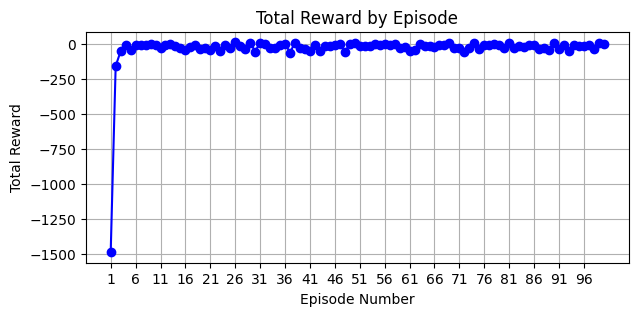

In [17]:
episode_rewards = {1: -1484.6547662354221, 2: -155.9898414344359, 3: -50.77762282752806, 4: -5.721737241859665, 5: -39.53443297431286, 6: -8.158875612471778, 7: -5.037349229883729, 8: -2.863827622024655, 9: 3.4798768231050206, 10: -8.658782613835744, 11: -30.03899698840209, 12: -4.377138591903868, 13: 1.4536053085324374, 14: -10.744986356998034, 15: -30.55165056318333, 16: -39.504297436066125, 17: -20.97079693533142, 18: -6.521197298205268, 19: -34.53601368799245, 20: -26.07206522500432, 21: -42.34070682272807, 22: -16.58261048684114, 23: -48.39689786948042, 24: -3.043980171873299, 25: -28.795981228307365, 26: 13.540395751546923, 27: -14.577625786447506, 28: -34.87136994215117, 29: 10.329436292918835, 30: -53.264875869884136, 31: 11.437910934522886, 32: -1.0752977453886037, 33: -27.675658262882656, 34: -24.1395932099737, 35: -3.190698739507022, 36: 2.101892595335593, 37: -60.08771715132144, 38: 11.51937868452855, 39: -27.286443666094687, 40: -37.935856173101556, 41: -47.17107553721111, 42: -6.328492933709148, 43: -49.52800668181351, 44: -14.033753648705826, 45: -12.442999724218078, 46: -8.44633295162614, 47: -0.7819723231969212, 48: -53.01396207964395, 49: -2.2839880563831505, 50: 6.4276485929753875, 51: -9.987262041335503, 52: -16.33516514448585, 53: -14.709052081138623, 54: -2.3132058853979096, 55: -5.880485234094251, 56: 2.2306803132921678, 57: -4.319046944762561, 58: 0.9066422623251192, 59: -27.662443490156342, 60: -22.270954944587064, 61: -46.67415995991306, 62: -45.02456024950201, 63: -1.172991907972471, 64: -14.315661072576445, 65: -12.776044865283904, 66: -16.99866640739871, 67: -5.729099774046534, 68: -9.624594383194177, 69: 9.885490627033864, 70: -30.32802279785323, 71: -30.553052609274857, 72: -54.49872722578776, 73: -24.913471328905516, 74: 11.193547981044984, 75: -34.57371891441139, 76: -8.437380886729345, 77: -7.1955646757300995, 78: -0.04028202573403217, 79: -9.029519959449482, 80: -26.205804607044445, 81: 9.632848618138802, 82: -25.575182846383477, 83: -13.496752651949537, 84: -23.322935265802325, 85: -5.243234293802955, 86: -7.6534367292407115, 87: -32.16063974888355, 88: -24.427615954186095, 89: -44.12380100469177, 90: 6.003274283207244, 91: -31.645713443607868, 92: -8.546519188667046, 93: -46.81684019704684, 94: -8.921679972479843, 95: -11.46287869822543, 96: -12.563388045311385, 97: -3.0054669887442174, 98: -36.21681890296962, 99: 10.825640668333103, 100: 0.3639264757992107}

# Préparer les données pour le tracé
episodes = list(episode_rewards.keys())
rewards = list(episode_rewards.values())

# Créer le graphique
plt.figure(figsize=(7, 3))  # Vous pouvez ajuster la taille selon vos besoins
plt.plot(episodes, rewards, marker='o', linestyle='-', color='b')
plt.title('Total Reward by Episode')
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')
plt.grid(True)
plt.xticks(range(1, len(episodes)+1, 5))  # Ajuster les marques sur l'axe des x pour chaque 5 épisodes
plt.show()

#### Best policy_model

In [30]:
# Assurez-vous que le chemin vers le modèle sauvegardé est correct
model_path = 'policy_model_episode_25'  # Remplacez X par le numéro de l'épisode que vous souhaitez charger
policy_model = load_model(model_path)

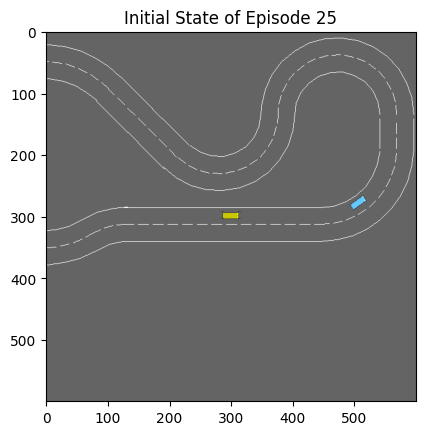

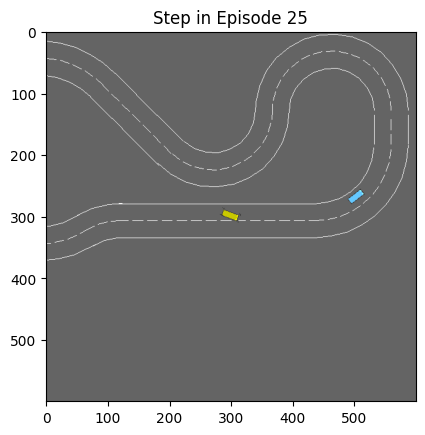

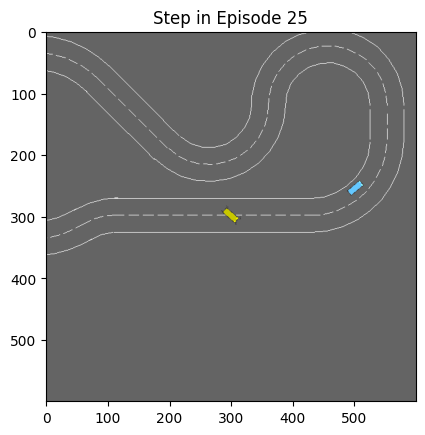

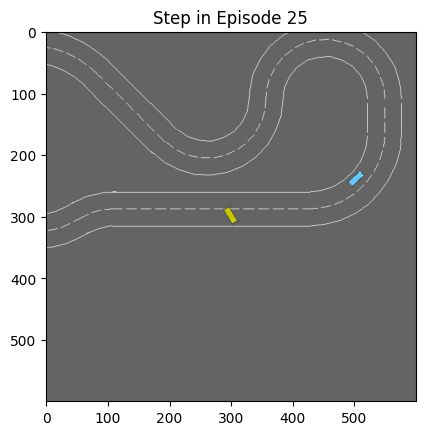

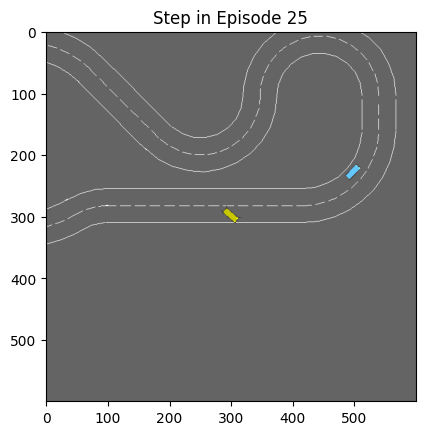

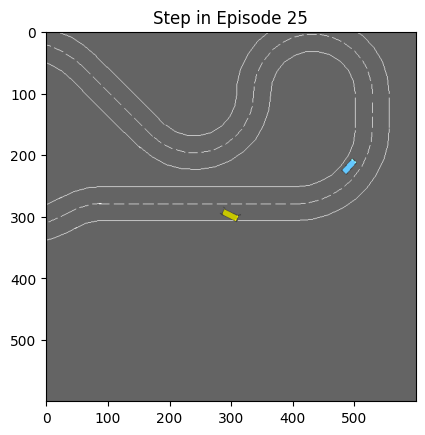

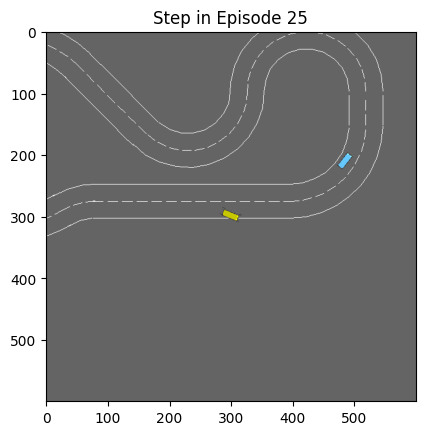

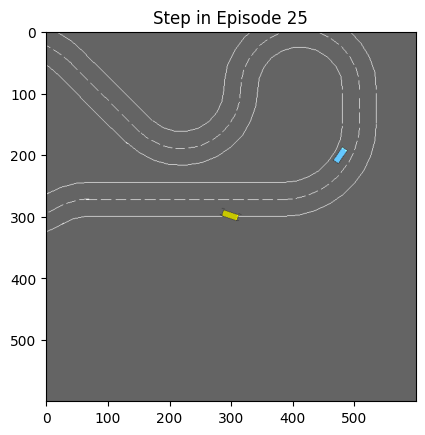

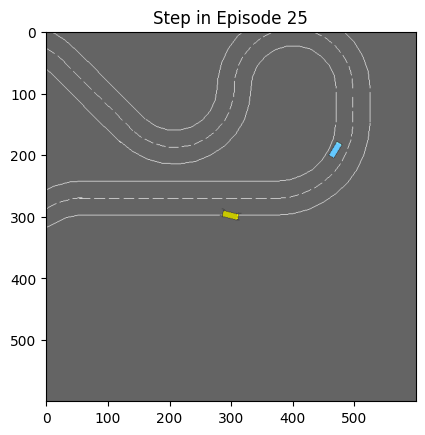

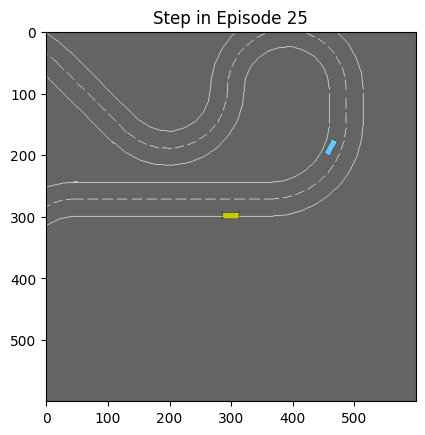

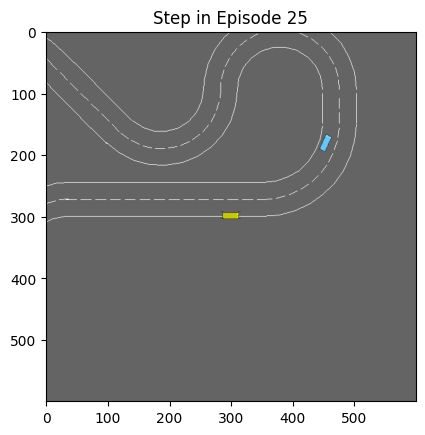

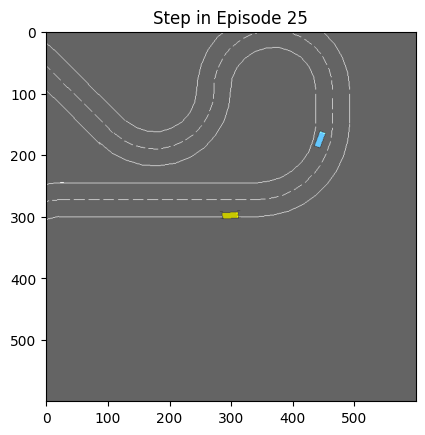

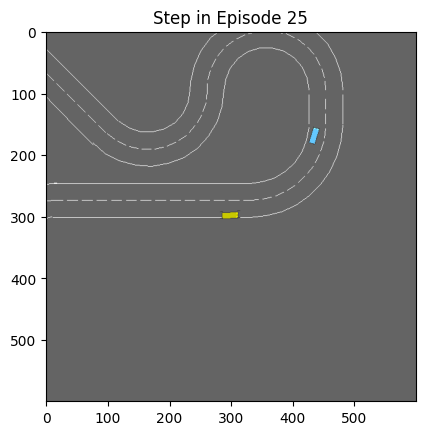

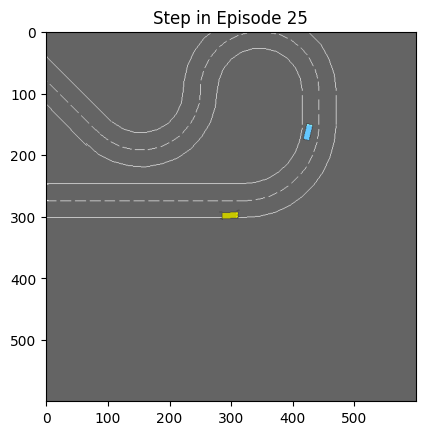

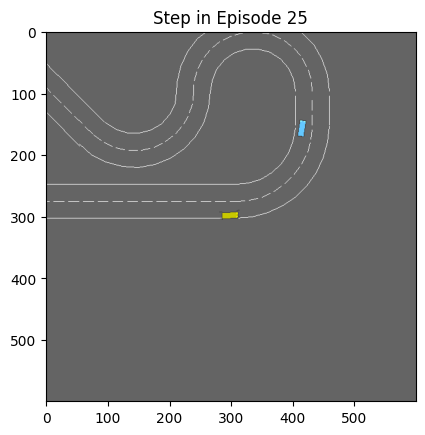

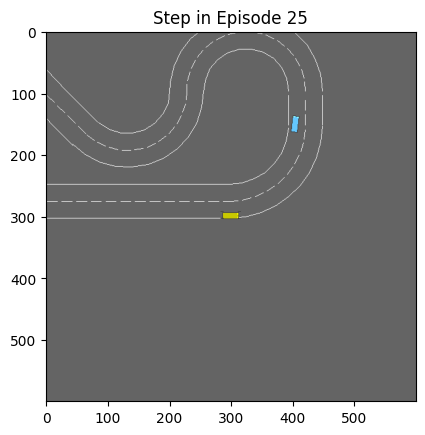

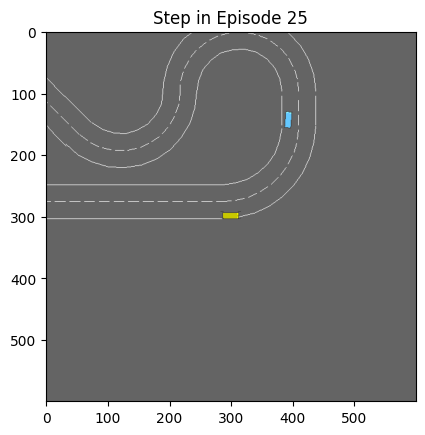

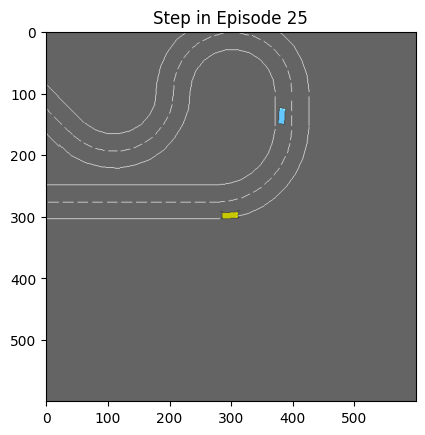

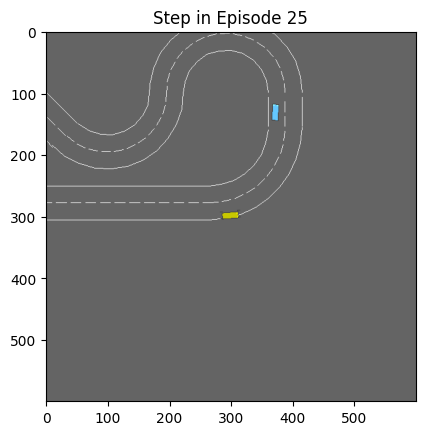

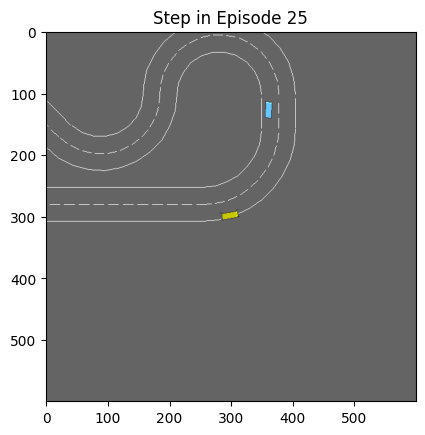

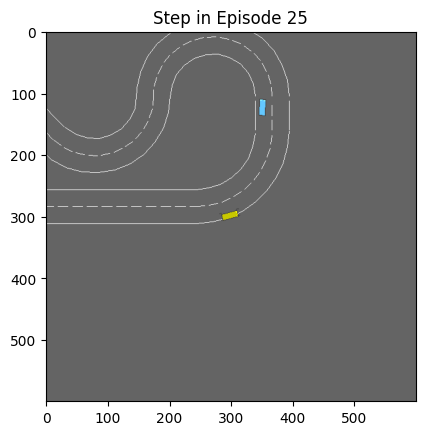

AttributeError: 'NoneType' object has no attribute 'get_image'

In [31]:
# for episode in range(num_episodes):

episode = 25
output = env.reset()
state = output[0] if isinstance(output, tuple) else output  
state = np.array(state).flatten()
plt.imshow(env.render())  
plt.title(f"Initial State of Episode {episode}")
plt.show()

done = False
while not done:
    state_tensor = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
    action = policy_model(state_tensor)[0].numpy()
    output = env.step(action)
    state = output[0] if isinstance(output, tuple) else output  
    state = np.array(state).flatten()  
    plt.imshow(env.render())
    plt.title(f"Step in Episode {episode}")
    plt.show()
    done = output[2] if isinstance(output, tuple) else False  

    if done:
        break

